In [1]:
import sys

sys.path.append('../../code/')
import os
import json
from datetime import datetime
import time
from math import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import igraph as ig

from load_data import load_citation_network, case_info

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_dir = '../../data/'
court_name = 'all'

# load into igraph

In [2]:
start = time.time()
if court_name == 'all':
    case_metadata = pd.read_csv(data_dir + 'clean/case_metadata_master.csv')

    edgelist = pd.read_csv(data_dir + 'clean/edgelist_master.csv')
else:
    net_dir = data_dir + 'clean/' + court_name + '/'
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)
        make_court_subnetwork(court_name, data_dir)

    case_metadata = pd.read_csv(net_dir + 'case_metadata.csv')

    edgelist = pd.read_csv(net_dir + 'edgelist.csv')
    edgelist.drop('Unnamed: 0', inplace=True, axis=1)

# create a dictonary that maps court listener ids to igraph ids
cl_to_ig_id = {}
cl_ids = case_metadata['id'].tolist()
for i in range(case_metadata['id'].size):
    cl_to_ig_id[cl_ids[i]] = i

# add nodes
V = case_metadata.shape[0]
g = ig.Graph(n=V, directed=True)
# g.vs['date'] = case_metadata['date'].tolist()
g.vs['name'] = case_metadata['id'].tolist()

# create igraph edgelist
cases_w_metadata = set(cl_to_ig_id.keys())
ig_edgelist = []
missing_cases = 0
start = time.time()
for row in edgelist.itertuples():

    cl_ing = row[1]
    cl_ed = row[2]

    if (cl_ing in cases_w_metadata) and (cl_ed in cases_w_metadata):
        ing = cl_to_ig_id[cl_ing]
        ed = cl_to_ig_id[cl_ed]
    else:
        missing_cases += 0
    
    ig_edgelist.append((ing, ed))

# add edges to graph
g.add_edges(ig_edgelist)

# add vertex attributes
g.vs['court'] =  case_metadata['court'].tolist()
g.vs['year'] = [int(d.split('-')[0]) for d in case_metadata['date'].tolist()]

end = time.time()

print '%d seconds for %d edges' % (end - start, len(g.es))

91 seconds for 24997230 edges


In [5]:
# g.write_graphml(data_dir + 'clean/entire_law_net.graphml')
# G = ig.read_graphml(data_dir + 'clean/entire_law_net.graphml')

# analyze

In [19]:
g.summary()

'IGRAPH DN-- 3760097 24997230 -- \n+ attr: court (v), name (v), year (v)'

# in degree distribution

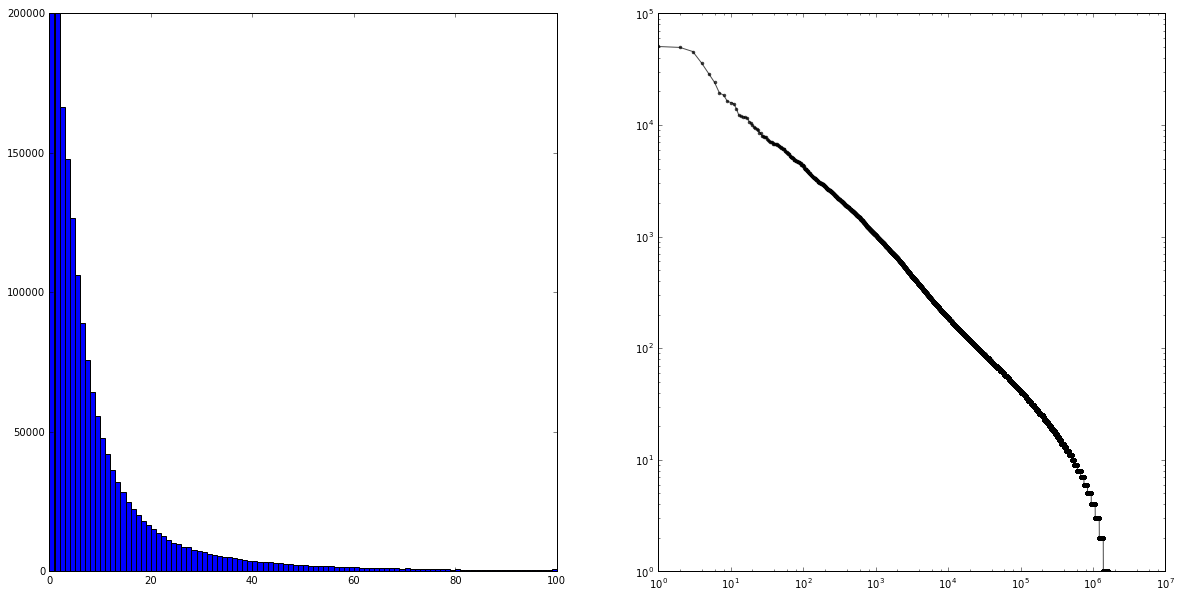

In [26]:
indegrees = g.indegree()

plt.figure(figsize = [20, 10])

plt.subplot(1,2,1)
dmax = 100
binwidth = 1
plt.hist(indegrees, bins=range(0, dmax + binwidth, binwidth));
plt.xlim([0, dmax])
plt.ylim([0, 2e5])


plt.subplot(1,2,2)
plt.loglog(sorted(indegrees, reverse=True), '-', marker='.', color='black',
           alpha=.7);

# Out degree distribution

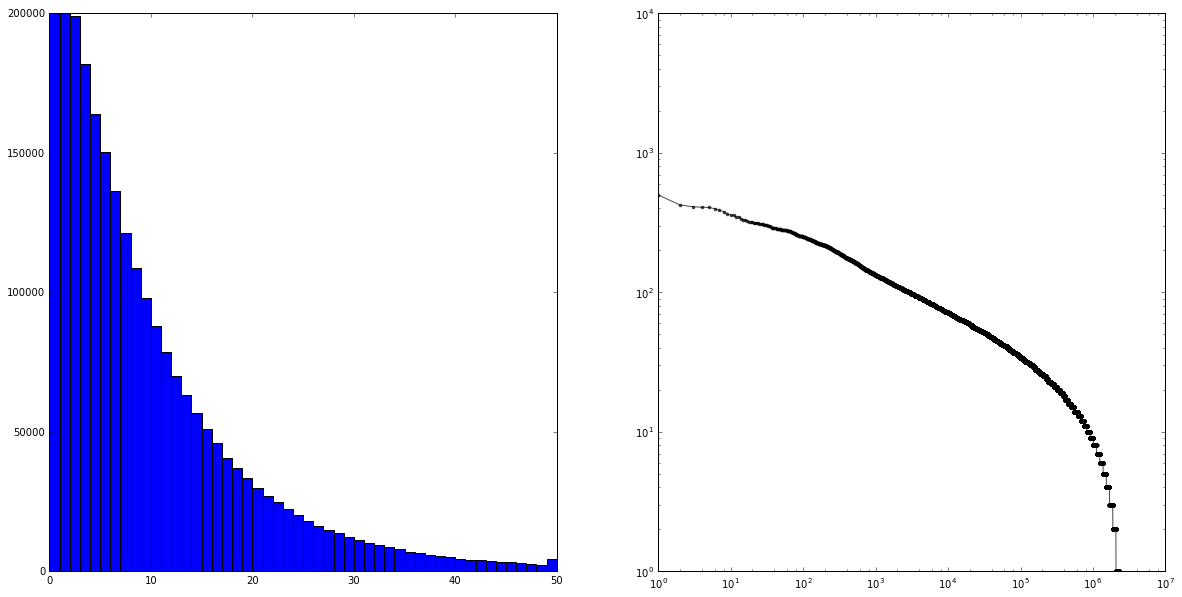

In [28]:
outdegrees = g.outdegree()

# out degree distribution
plt.figure(figsize = [20, 10])

plt.subplot(1,2,1)
dmax = 50
binwidth = 1
plt.hist(outdegrees, bins=range(0, dmax + binwidth, binwidth));
plt.xlim([0, dmax])
plt.ylim([0, 2e5])


plt.subplot(1,2,2)
plt.loglog(sorted(outdegrees, reverse=True), '-', marker='.', color='black',
           alpha=.7);

# degree statistics by year

In [93]:
year_range = range(1631, 2016 + 1)
year_quotient = pd.DataFrame(index=year_range, columns=['count', 'avg_indegree', 'avg_outdegree'])

count number of cases

In [104]:
year_counts = {y: 0 for y in year_quotient.index}
for v in g.vs:
    year_counts[v['year']] += 1

year_quotient['count'] = year_counts.values()

get average in/out degrees

In [99]:
indegrees = g.indegree()
outdegrees = g.outdegree()

indegs_counts = {y: [] for y in year_quotient.index}
outdegs_counts = {y: [] for y in year_quotient.index}

# get degrees for cases in each year
for i in range(len(g.vs)):
    year = g.vs[i]['year']
    
    indeg = indegrees[i]
    outdeg = outdegrees[i]

    indegs_counts[year].append(indeg)
    outdegs_counts[year].append(outdeg)
    
# average the degrees by yaer  
for y in indegs_counts.keys():
    indegs = indegs_counts[y]
    outdegs = outdegs_counts[y]
    
    
    if len(indegs) == 0:
        year_quotient.loc[y, 'avg_indegree'] = 0
    else:
        year_quotient.loc[y,'avg_indegree'] = np.mean(indegs)
        
        
        
    if len(outdegs) == 0:
        year_quotient.loc[y, 'avg_outdegree'] = 0
    else:
        year_quotient.loc[y,'avg_outdegree'] = np.mean(outdegs)

In [105]:
year_quotient

,count,avg_indegree,avg_outdegree
1631,1,0,0
1632,0,0,0
1633,0,0,0
1634,0,0,0
1635,0,0,0
1636,0,0,0
1637,0,0,0
1638,0,0,0
1639,0,0,0
1640,0,0,0


# Plot the time series

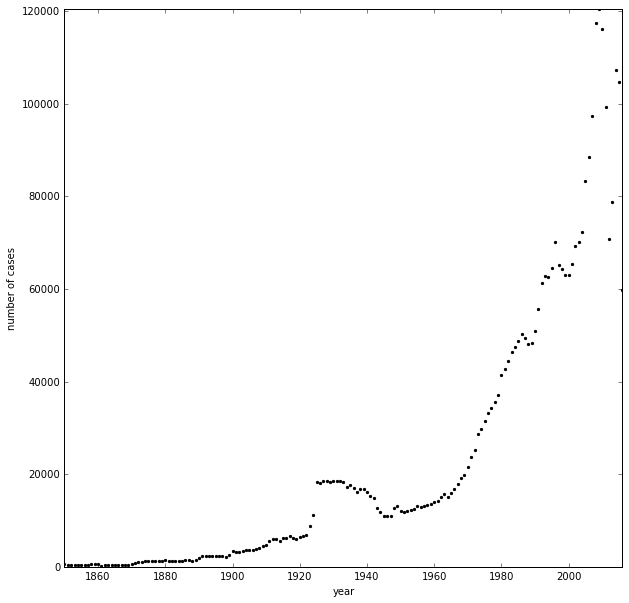

In [124]:
plt.figure(figsize=[10, 10])
plt.scatter(year_quotient.index,
            year_quotient['count'],
            marker='.',
            color='black')
plt.ylim(0, max(year_quotient['count']))
plt.xlim([1850, 2016])
plt.xlabel('year')
plt.ylabel('number of cases')

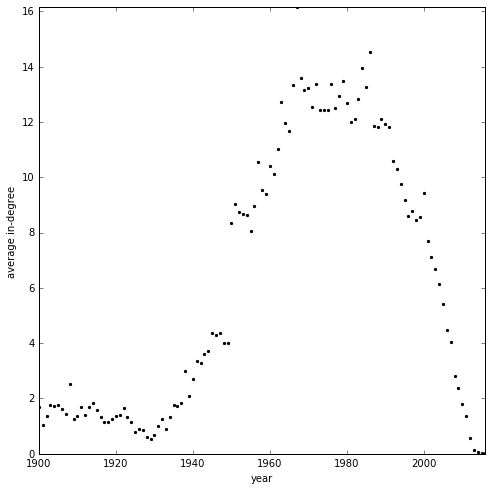

In [130]:
plt.figure(figsize=[8, 8])
plt.scatter(year_quotient.index,
            year_quotient['avg_indegree'],
            marker='.',
            color='black')
plt.ylim(0, max(year_quotient['avg_indegree']))
plt.xlim([1900, 2016])
plt.xlabel('year')
plt.ylabel('average in-degree')

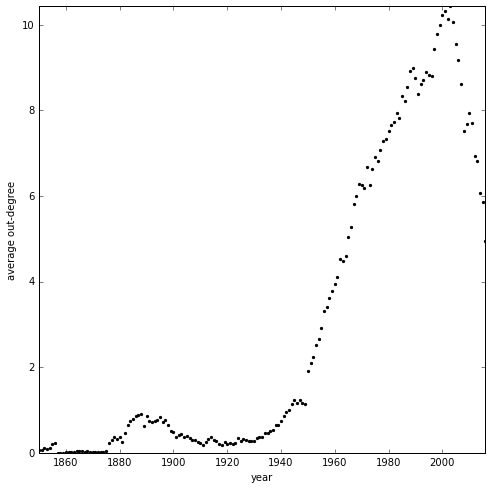

In [132]:
plt.figure(figsize=[8, 8])
plt.scatter(year_quotient.index,
            year_quotient['avg_outdegree'],
            marker='.',
            color='black')
plt.ylim(0, max(year_quotient['avg_outdegree']))
plt.xlim([1850, 2016])
plt.xlabel('year')
plt.ylabel('average out-degree')